# Time Series dataset for prediction

## Crawl data NO2 menggunakan openeo

In [1]:
import openeo
import os
import xarray as xr
import pandas as pd
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

coordinates = [
    [113.68677516434411, -8.165890715645048],
    [113.68767635393294, -8.178366137853942],
    [113.7212614574645, -8.178954488616213],
    [113.72266252355564, -8.167199225119404],
    [113.68677516434411, -8.165890715645048]
]

# 3️⃣ Hitung bounding box otomatis dari koordinat
lons = [coord[0] for coord in coordinates]
lats = [coord[1] for coord in coordinates]

bbox = {
    "west": min(lons),
    "south": min(lats),
    "east": max(lons),
    "north": max(lats)
}

# 4️⃣ Tampilkan area yang tercakup
print("🗺️ Area coverage (Jember AOI):")
print(f"Longitude: {bbox['west']}°E to {bbox['east']}°E")
print(f"Latitude:  {bbox['south']}°S to {bbox['north']}°S")

# 5️⃣ Buat AOI GeoJSON sederhana untuk dipakai di OpenEO
aoi = {
    "type": "Polygon",
    "coordinates": [coordinates]
}

print("\n✅ AOI untuk Jember sudah siap digunakan.")


Authenticated using refresh token.
🗺️ Area coverage (Jember AOI):
Longitude: 113.68677516434411°E to 113.72266252355564°E
Latitude:  -8.178954488616213°S to -8.165890715645048°S

✅ AOI untuk Jember sudah siap digunakan.


In [2]:
# Create a datacube with daily data
print("Loading data collection...")
cube = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2021-09-20", "2025-09-25"],
    spatial_extent=bbox,
    bands=["NO2"]
)

# Add basic filtering to reduce data volume
cube = cube.filter_bands(["NO2"])

# Perform daily aggregation
print("Aggregating data to daily values...")
cube = cube.aggregate_temporal_period(
    period="day",  # Agregasi per hari
    reducer="mean"  # Menggunakan nilai rata-rata untuk setiap hari
)

print("Processing complete. Ready for download.")

Loading data collection...
Aggregating data to daily values...
Processing complete. Ready for download.


In [3]:
# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Download the data
try:
    print("Downloading data...")
    cube.download("results/no2_jember.nc")
    print("Data successfully downloaded to results/no2_jember.nc")

except Exception as e:
    print(f"Error downloading data: {e}")
    
    # Try batch processing as alternative
    try:
        print("\nTrying batch processing...")
        batch_job = cube.execute_batch(outputfile="results/no2_jember.nc")
        
        while True:
            status = batch_job.status()
            print(f"Job status: {status}")
            if status == 'finished':
                print("Download completed successfully")
                break
            elif status == 'error':
                raise Exception("Batch job failed")
    
    except Exception as e2:
        print(f"All download attempts failed.")
        print(f"Error: {e2}")
        raise

Error downloading data: HTTPSConnectionPool(host='openeo.dataspace.copernicus.eu', port=443): Read timed out. (read timeout=1800)

Trying batch processing...
0:00:00 Job 'j-2510251135504fb68bc7f1b3a77f6453': send 'start'
0:00:14 Job 'j-2510251135504fb68bc7f1b3a77f6453': created (progress 0%)
0:00:19 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:00:26 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:00:34 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:00:44 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:00:57 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:01:13 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:01:32 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:01:57 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:02:27 Job 'j-2510251135504fb68bc7f1b3a77f6453': running (progress N/A)
0:03:05 Job 'j-2510251135504fb68bc7f1b3a77f6453': 

## Transform data dari NC ke CSV

In [9]:
!pip install netCDF4

import netCDF4
import pandas as pd
import numpy as np

# 1. Baca file NetCDF
file_path = "C:\\Users\\mjavi\\Documents\\Pendidikan\\UTM\\matkul\\PSD\\Tugas 3\\results\\no2_jember.nc"
ds = netCDF4.Dataset(file_path)

# 2. Tampilkan struktur file
print(ds)

# 3. Ambil variabel yang tersedia
print(ds.variables.keys())

# 4. Ambil variabel waktu dan NO2
time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

# 5. Konversi waktu ke datetime
time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

# 6. Jika data NO2 berdimensi lebih dari 1 (misalnya [time, lat, lon]),
# kita rata-ratakan agar menjadi satu nilai per waktu
if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

# 7. Buat DataFrame
df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

# 8. Simpan ke CSV
df.to_csv("no2_jember.csv", index=False)
print("✅ File no2_jember.csv berhasil dibuat.")
print(df.head())

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.9
    institution: Copernicus Data Space Ecosystem openEO API - 0.68.0a10.dev20250930+2976
    description: 
    title: 
    dimensions(sizes): t(1458), y(1), x(1)
    variables(dimensions): int32 t(t), float64 x(x), float64 y(y), |S1 crs(), float32 NO2(t, y, x)
    groups: 
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])
✅ File no2_jember.csv berhasil dibuat.
                  time       NO2
0  2021-09-20 00:00:00       NaN
1  2021-09-21 00:00:00       NaN
2  2021-09-22 00:00:00       NaN
3  2021-09-23 00:00:00 -0.000003
4  2021-09-24 00:00:00       NaN


## Memprosessing data jika ada missing values  dengan interpolasi

In [10]:
import pandas as pd

df = pd.read_csv("no2_jember.csv")

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.set_index('time')

df['NO2'] = df['NO2'].interpolate(method='time')

print(df.isna().sum())

n_lags = 4

supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

# drop NaN value
supervised = supervised.dropna()

print("📅 Head of Data:")
print(supervised.head())

print("")
print("📦 Data info:")
supervised.info

NO2    3
dtype: int64
📅 Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2021-09-27 -0.000003  0.000002  0.000008  0.000014  0.000014
2021-09-28  0.000002  0.000008  0.000014  0.000014  0.000013
2021-09-29  0.000008  0.000014  0.000014  0.000013  0.000013
2021-09-30  0.000014  0.000014  0.000013  0.000013  0.000013
2021-10-01  0.000014  0.000013  0.000013  0.000013  0.000012

📦 Data info:


<bound method DataFrame.info of             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2021-09-27 -0.000003  0.000002  0.000008  0.000014  0.000014
2021-09-28  0.000002  0.000008  0.000014  0.000014  0.000013
2021-09-29  0.000008  0.000014  0.000014  0.000013  0.000013
2021-09-30  0.000014  0.000014  0.000013  0.000013  0.000013
2021-10-01  0.000014  0.000013  0.000013  0.000013  0.000012
...              ...       ...       ...       ...       ...
2025-09-20  0.000024  0.000022  0.000020  0.000017  0.000015
2025-09-21  0.000022  0.000020  0.000017  0.000015  0.000013
2025-09-22  0.000020  0.000017  0.000015  0.000013  0.000017
2025-09-23  0.000017  0.000015  0.000013  0.000017  0.000031
2025-09-24  0.000015  0.000013  0.000017  0.000031  0.000012

[1451 rows x 5 columns]>

## Normalisasi data min-max

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Pisahkan fitur dan target
X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

# Normalisasi Min-Max
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Ubah index time jadi kolom lagi
supervised = supervised.reset_index()

# Konversi kembali ke Dataframe
normalized_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Sebelum normalisasi:\n", X.head())
print("\nSesudah normalisasi:\n", normalized_df.head())

Sebelum normalisasi:
             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2021-09-27 -0.000003  0.000002  0.000008  0.000014
2021-09-28  0.000002  0.000008  0.000014  0.000014
2021-09-29  0.000008  0.000014  0.000014  0.000013
2021-09-30  0.000014  0.000014  0.000013  0.000013
2021-10-01  0.000014  0.000013  0.000013  0.000013

Sesudah normalisasi:
    NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.096852  0.177395  0.257937  0.338480
1  0.177395  0.257937  0.338480  0.333293
2  0.257937  0.338480  0.333293  0.328107
3  0.338480  0.333293  0.328107  0.322920
4  0.333293  0.328107  0.322920  0.317733


## Membuat model dengan K-NN regression

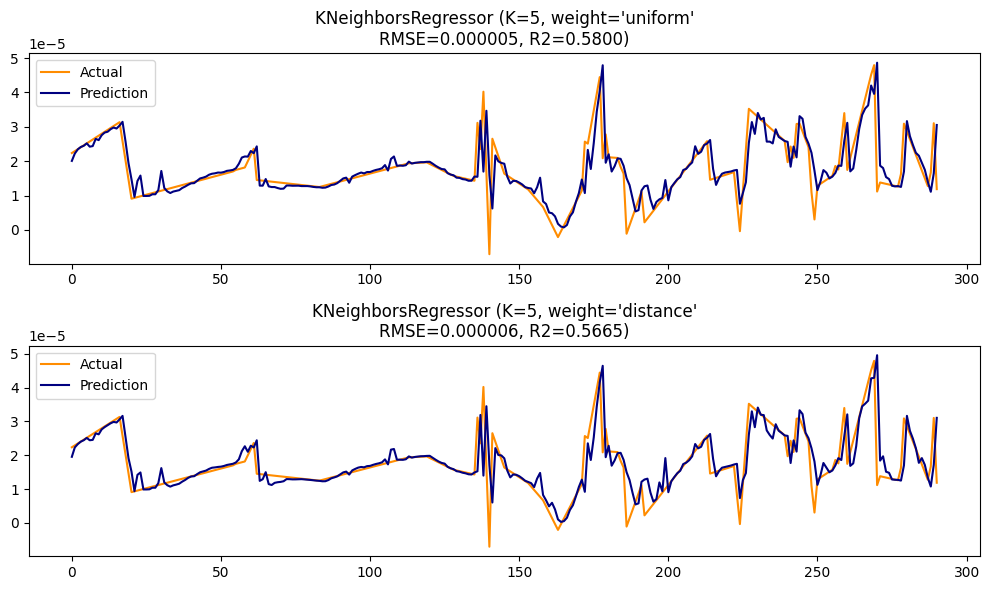

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'darkorange', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'navy', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()